# Assignment

1.	Find anomalies in the data set to automatically flag events
2.	Categorize anomalies as “System fault” or “external event”
3.	Provide any other useful conclusions from pattern in the data set
4.	Visualize inter-dependencies of the features in the dataset



# Reading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
df1 = pd.read_csv("SL132001-data (11).csv",skiprows=[1] )
units = pd.read_csv("SL132001-data (11).csv").iloc[0].tolist()[:-1]
df2 = pd.read_csv("SL132001-data (12).csv", skiprows=[1])
df = pd.concat([df1,df2], ignore_index=True).sort_values(by='Timestamp')
columns = df.columns[:-1]
df.head()

,Date,Time GMT -4,Timestamp,Ozone - Low Conc.,Hydrogen Sulfide - Low Conc.,Total VOCs (ppm) - PID,Carbon Dioxide - Low Conc.,Particulate Matter 1,Particulate Matter 2.5,Particulate Matter 10,Temperature (Internal),Humidity (Internal),Temperature (External),Humidity (External),Latitude,Longitude,Unnamed: 16
0,26/05/2020,8:51:45,1590497505000,0.210,0.000,0.266,466.607,18.270,19.519,19.759,23.87,45.76,23.25,47.54,43.962193,-79.267792,NaN
1,26/05/2020,8:52:44,1590497564000,0.217,0.001,0.268,467.189,14.326,15.149,15.149,23.81,45.93,23.18,47.75,43.962193,-79.267792,NaN
2,26/05/2020,8:53:44,1590497624000,0.222,0.001,0.269,468.038,10.830,11.453,11.453,23.91,45.94,23.25,47.84,43.962193,-79.267792,NaN
3,26/05/2020,8:54:44,1590497684000,0.209,0.001,0.270,473.823,11.914,12.798,13.038,23.85,45.89,23.31,47.87,43.962193,-79.267792,NaN
4,26/05/2020,8:55:43,1590497743000,0.208,0.001,0.269,477.804,13.232,13.992,13.992,24.00,46.43,23.29,47.91,43.962193,-79.267792,NaN


What we have is two weeks of time series data taken between March 26 2020- June 09 2020 somewhere in Stouffville,ON, where the data has been sampled by minute intervals. We have measurements of various chemical compound readings such as Hydrogen Sulfide, Ozone, Carbon Dioxide, VOCs, and Particulate matters of various sizes. We also have internal (device) and external(ambient) temperature and humidity measurements. 

All the data we are dealing with is time-series data, this means that some traditional probabilistic methods will not work if the data is not stationary. Our main task is to identify anomalies, then to categorize them as "System fault" or "External event". "System fault" will refer to anomalies caused by the device/sensors, and "External event" will refer to naturally occurring anomalies. For example, the sensor malfunctioning and recording garbage would be a "System fault" anomaly, while a sudden spike in $CO_2$ due to a fire nearby would an "External event" anomaly.

# Plotting the Data

Let us first plot the data and I will add a vertical divider between the 2 weeks of data to indicate when the data from the second week begins.

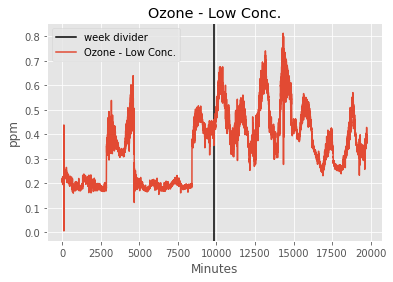

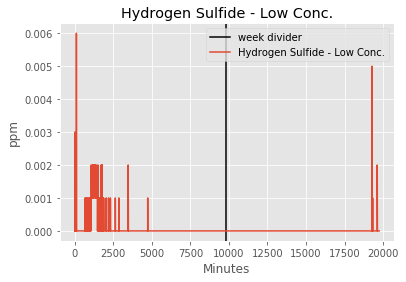

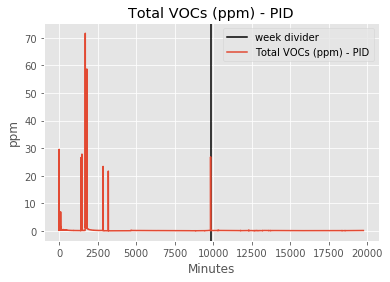

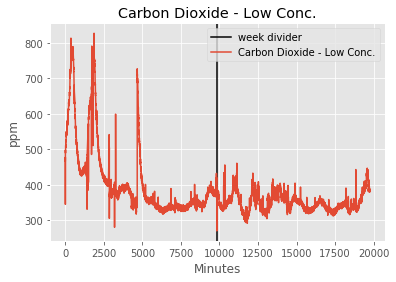

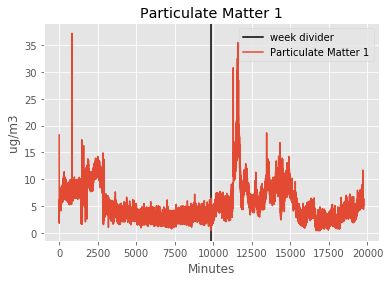

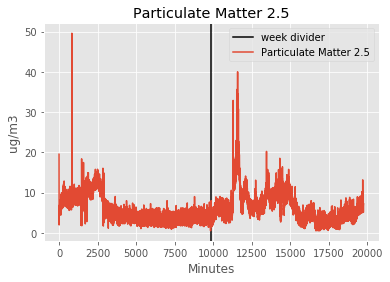

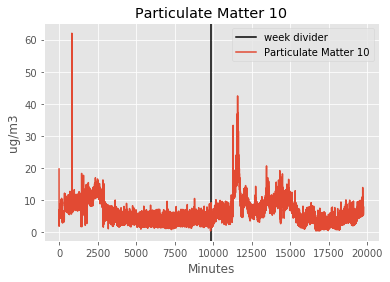

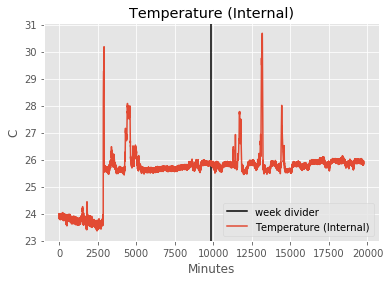

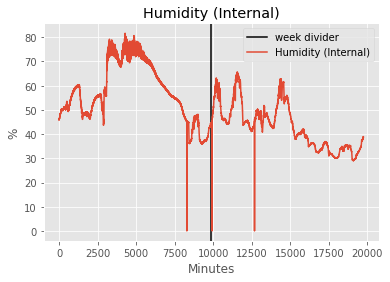

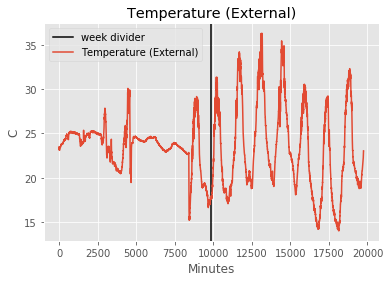

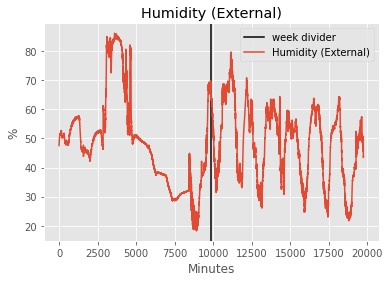

In [3]:
columns = df.columns

for idx, column in enumerate(columns[3:14]):
    plt.figure()
    plt.axvline(x=df1.shape[0], color='black', label="week divider")
    df[column].plot(title=column)
    plt.xlabel("Minutes")
    plt.ylabel(units[idx+3])
    plt.legend()

# Week 1 vs Week 2

We can already see some differences between the 2 weeks of data. Most notably are the differences between the VOCs, Humidity, Temperature, Ozone, and $CO_2$ readings. The VOCs readings for the first week are sometimes magnitudes (x100) higher than the second week data. The external humidity, external temperature, $CO_2$, and ozone data for the second week have a daily cyclical  pattern, while the first week data doesn't. Lastly the $CO_2$ fluctuations in the first week are much larger than the second week. There is clearly some large anomaly here. What we need to determine is which weeks data is the norm and which week's data is the anomaly.

## Frequency Analysis

We can more clearly see the cyclical differences by viewing the frequency spectrum of the data via a Fourier transform. We will apply the Fourier transform to the Ozone, $CO_2$, Temperature, and Humidity data because these measurements should naturally have a strong daily frequency present. 

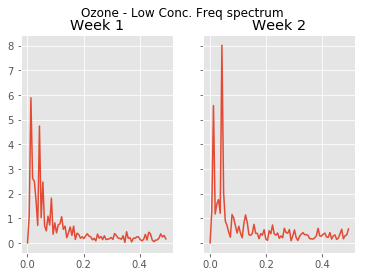

Week 1 dominant freq/period:0.012/82.0 hours
Week 2 dominant freq/period: 0.042/23.714 hours




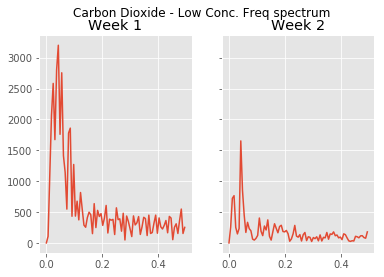

Week 1 dominant freq/period:0.043/23.429 hours
Week 2 dominant freq/period: 0.042/23.714 hours




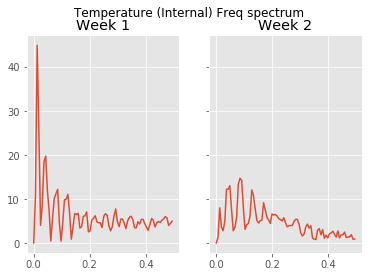

Week 1 dominant freq/period:0.012/82.0 hours
Week 2 dominant freq/period: 0.084/11.857 hours




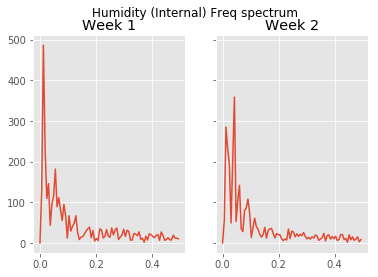

Week 1 dominant freq/period:0.012/82.0 hours
Week 2 dominant freq/period: 0.042/23.714 hours




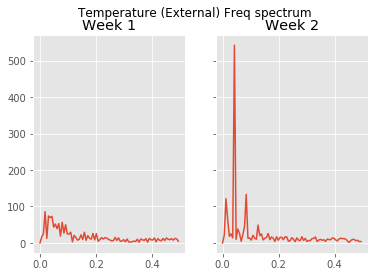

Week 1 dominant freq/period:0.018/54.667 hours
Week 2 dominant freq/period: 0.042/23.714 hours




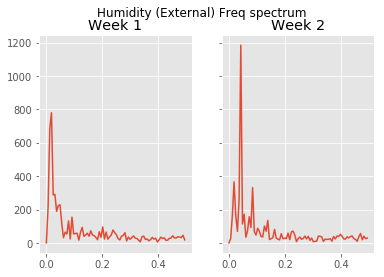

Week 1 dominant freq/period:0.018/54.667 hours
Week 2 dominant freq/period: 0.042/23.714 hours




In [4]:
def get_fft(x):
    N=len(x)
    x_fft = np.fft.fft(x)
    freq = np.fft.fftfreq(N)
    return freq[:N//2], x_fft[:N//2]

def detrend(x,degree):
    N=len(x)
    time = np.linspace(0,N, N)
    p = np.poly1d(np.polyfit(time,x, degree))
    x= x - p(time)
    return x
    

nonstationary_idx = [3,6,10,11,12,13]

for idx in nonstationary_idx:
    measure = columns[idx]
    
        
    x1 = detrend(df1[measure].values[::60],3)
    x2 = detrend(df2[measure].values[::60],3)
    x1_freq, x1_fft = get_fft(x1)
    x2_freq, x2_fft = get_fft(x2)
    fig, axs = plt.subplots(1,2, sharey=True)
    fig.suptitle(f"{measure} Freq spectrum")
    axs[0].plot(x1_freq,np.abs(x1_fft))
    axs[0].set_title("Week 1")
    axs[1].plot(x2_freq,np.abs(x2_fft))
    axs[1].set_title("Week 2")
    i =np.argmax(np.abs(x1_fft))
    j =np.argmax(np.abs(x2_fft))
    plt.show()
    print(f"Week 1 dominant freq/period:{round(x1_freq[i],3)}/{round(1/x1_freq[i],3)} hours")
    print(f"Week 2 dominant freq/period: {round(x2_freq[j],3)}/{round(1/x2_freq[j],3)} hours")
    print("\n")

Based on the fact that the first week data of Humidity, Temperature, Ozone, and $CO_2$ do not exhibit strong daily oscillations, which should be present naturally, I would then conclude that there is some "System fault" anomaly present in the the data for the first week. I believe the sensors for the first week were not functioning properly. This anomaly cannot be attributed to an external event, unless there was some extreme weather anomaly going on for several days. 

## Distribution Differences

The hypothesis that the entire first week data has "System fault" anomaly present can further be justified by comparing the distribution of the two weeks. We can then also build probabilistic models using these distributions to automatically detect external anomalies. We begin by comparing the Particulate matter(1,2.5,10), VOC, and Hydrogen Sulfide distributions.


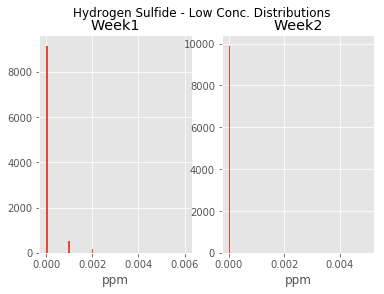

Week 1: Mean= 0.0001, Var= 0.0
Week 2: Mean= 0.0, Var= 0.0


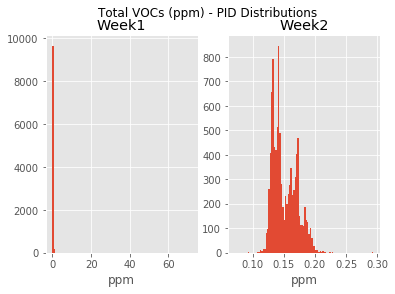

Week 1: Mean= 0.2108, Var= 1.3818
Week 2: Mean= 0.1514, Var= 0.0004


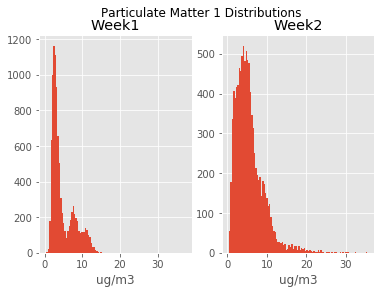

Week 1: Mean= 4.6625, Var= 8.9701
Week 2: Mean= 5.5859, Var= 13.3004


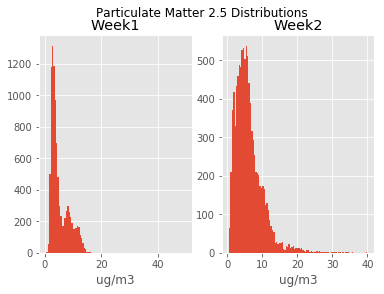

Week 1: Mean= 5.0905, Var= 10.2398
Week 2: Mean= 6.093, Var= 15.9147


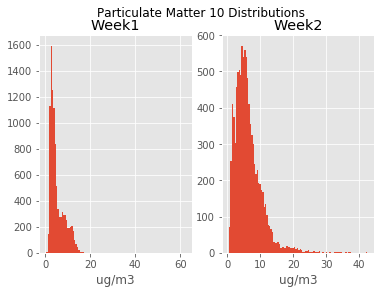

Week 1: Mean= 5.2054, Var= 10.4389
Week 2: Mean= 6.3006, Var= 17.1175


In [5]:
stationary_idx = [4,5,7,8,9]
for idx in stationary_idx:
    measure = columns[idx]
    
    fig, axs = plt.subplots(1,2, sharey=False)
    axs[0].set_title("Week1")
    axs[1].set_title("Week2")
    axs[0].set_xlabel(units[idx])
    axs[1].set_xlabel(units[idx])
    fig.suptitle(f"{measure} Distributions")
    df1[measure].hist(bins = 100, ax=axs[0])
    df2[measure].hist(bins = 100, ax=axs[1])
    plt.show()
    print(f"Week 1: Mean= {round(df1[measure].mean(),4)}, Var= {round(df1[measure].var(),4)}")
    print(f"Week 2: Mean= {round(df2[measure].mean(),4)}, Var= {round(df2[measure].var(),4)}")

We can apply various hypothesis tests such as the Kolmogorov-Smirnov test or Chi-Squared test to determine quantitatively the differences between the distribution, however because the differences are so great, we can visually see it. Instead let us look the distribution of Ozone, $CO_2$, Temperature, and Humidity data. More specifically we will look at the distribution of the derivative(rate of change), which will also make the data stationary. First let us simply see the derivative of these measurements before we look at their distribution because we can draw useful insights.

## Differencing/Derivative Plot

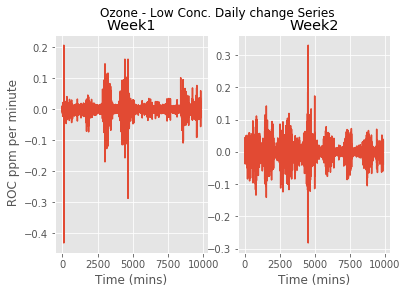

Week 1: Mean= 0.0, Var= 0.0003
Week 2: Mean= -0.0, Var= 0.0005


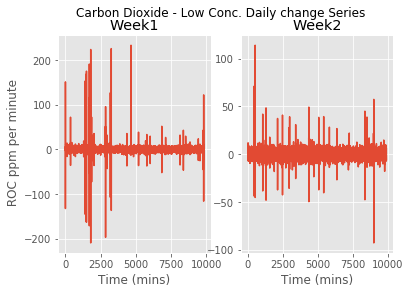

Week 1: Mean= -0.0086, Var= 82.4453
Week 2: Mean= -0.0004, Var= 21.0241


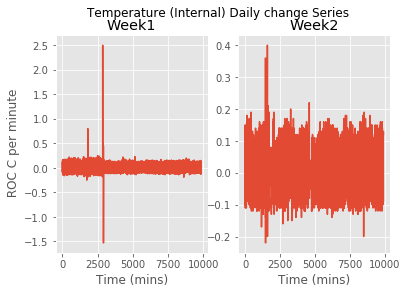

Week 1: Mean= 0.0002, Var= 0.0068
Week 2: Mean= 0.0, Var= 0.0045


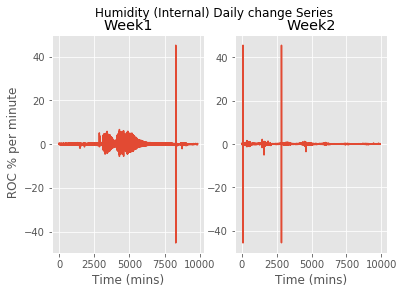

Week 1: Mean= -0.0001, Var= 1.8135
Week 2: Mean= -0.0006, Var= 1.2862


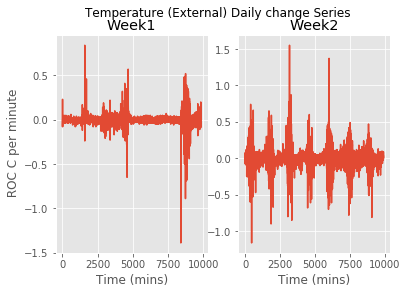

Week 1: Mean= -0.0006, Var= 0.0043
Week 2: Mean= 0.0005, Var= 0.0139


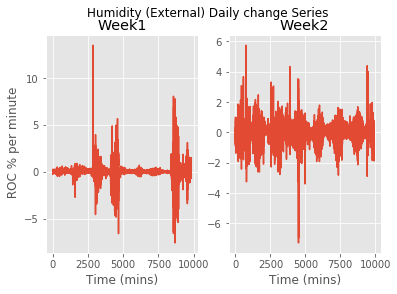

Week 1: Mean= 0.0022, Var= 0.3795
Week 2: Mean= -0.0026, Var= 0.2856


In [130]:

for idx in nonstationary_idx:
    measure = columns[idx]
    
    fig, axs = plt.subplots(1,2, sharey=False)
    axs[0].set_title("Week1")
    axs[1].set_title("Week2")
    axs[0].set_xlabel("Time (mins)")
    axs[1].set_xlabel("Time (mins)")
    axs[0].set_ylabel(f" ROC {units[idx]} per minute")
    fig.suptitle(f"{measure} Daily change Series")
    df1[measure].diff(1).plot( ax=axs[0])
    df2[measure].diff(1).plot( ax=axs[1])
    plt.show()
    print(f"Week 1: Mean= {round(df1[measure].diff().mean(),4)}, Var= {round(df1[measure].diff().var(),4)}")
    print(f"Week 2: Mean= {round(df2[measure].diff().mean(),4)}, Var= {round(df2[measure].diff().var(),4)}")

Although we have already said that the entire first weeks data has some "System fault" anomaly present, by looking at the rate of change in Humidity, Temperature, $CO_2$, and Ozone, we can see something interesting between the 5000-8000 minute range for the first week. The rate of change seems to be very small for all of these quantities. This is an anomaly, probably a piece of a larger anomaly. I think the detectors/sensors were somehow blocked from detecting during this period. Now lets look at the distribution of this data.

## Differencing/Derivative Distribution

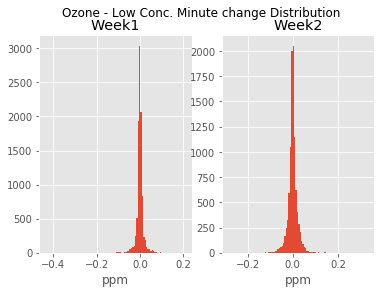

Week 1: Mean= 0.0, Var= 0.0003
Week 2: Mean= -0.0, Var= 0.0005


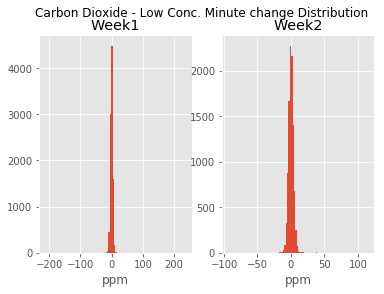

Week 1: Mean= -0.0086, Var= 82.4453
Week 2: Mean= -0.0004, Var= 21.0241


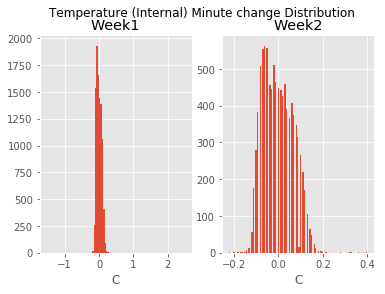

Week 1: Mean= 0.0002, Var= 0.0068
Week 2: Mean= 0.0, Var= 0.0045


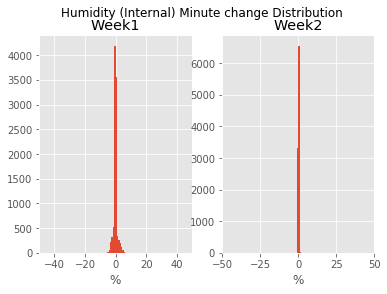

Week 1: Mean= -0.0001, Var= 1.8135
Week 2: Mean= -0.0006, Var= 1.2862


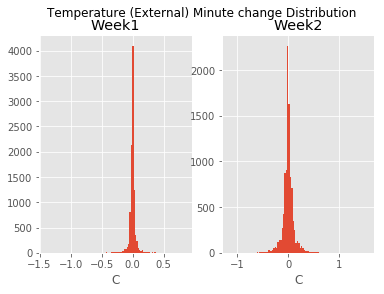

Week 1: Mean= -0.0006, Var= 0.0043
Week 2: Mean= 0.0005, Var= 0.0139


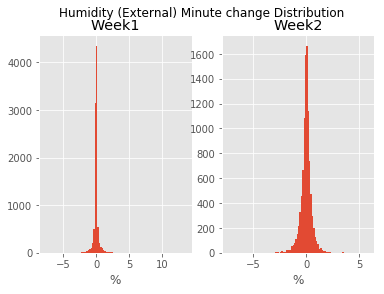

Week 1: Mean= 0.0022, Var= 0.3795
Week 2: Mean= -0.0026, Var= 0.2856


In [7]:
for idx in nonstationary_idx:
    measure = columns[idx]
    
    fig, axs = plt.subplots(1,2, sharey=False)
    axs[0].set_title("Week1")
    axs[1].set_title("Week2")
    axs[0].set_xlabel(units[idx])
    axs[1].set_xlabel(units[idx])
    fig.suptitle(f"{measure} Minute change Distribution")
    df1[measure].diff(1).hist( ax=axs[0], bins=100)
    df2[measure].diff(1).hist( ax=axs[1], bins=100)
    plt.show()
    print(f"Week 1: Mean= {round(df1[measure].diff().mean(),4)}, Var= {round(df1[measure].diff().var(),4)}")
    print(f"Week 2: Mean= {round(df2[measure].diff().mean(),4)}, Var= {round(df2[measure].diff().var(),4)}")

Something important we can see is that week one is mostly concentrated around the mean, however it's outliers are much more extreme. 

# Probability Models to Detect Anomalies

Let us now model these processes, such that we can automatically detect certain anomalies. We will only use the seconds week data to make our models, because the first weeks data is riddled with anomalies. Something is wrong with the first weeks data, naturally we should not be getting that kind of data.

For each variable $X$ we will estimate $P(X)$ with kernel density estimation. Doing this we will then be able to assign a "probability" to new observations, if the "probability" is below a certain threshold, we can mark this observation as an anomaly. 

So we define an anomaly as such:

Given an observation $X$, it is an anomaly if $P(X)< \epsilon$ for some cutoff probability $\epsilon >0$

In [73]:
from scipy.stats import gaussian_kde

models = {}

for idx in stationary_idx+nonstationary_idx:
    measure = columns[idx]
    if measure in columns[nonstationary_idx]:
        dataset = df2[measure].diff().values[1:]
    else:
        dataset = df2[measure].values
    
    models[measure] = gaussian_kde(dataset)


In [80]:
def anomaly_detector(data,measure, epsilon):
    """
    data: (nx1) array
        The data array
    measure: string
        The observable that was measured, example: rate of change in temperature
    epsilon: float
        The probability cut off, observations with probabilities less 
        than epsilon are anomalies
    
    :return array
        Returns a (Mx2) array of instances(time) of anomalies and their probabilities
    """
    model = models[measure]
    probs = model.pdf(data)
    anomalies = [[i,v] for i,v in enumerate(probs) if float(v) < epsilon]
    return np.array(anomalies)


    

Above we have estimated probability distributions for various measures/observables, and we have designed a simple algorithm to automatically flag anomalies. Our method requires choosing a cutoff probability $\epsilon$, which can usually be done by looking at the estimated probability of an extreme event ($n\sigma$ event) from our data. The one thing our model/algorithm does not tell us, is what kinds of anomaly is present. We do not know if the anomaly is a "System fault" or "External event" anomaly. There is really no good way of knowing which anomaly we are dealing with besides the naive way. Naively we can flag anomalies as "External event" if such an event is physically possible. Impossible events will be flagged as "System fault", because these events do not occur naturally, and must therefor be the fault of the sensor/device. For example let us look at Internal Humidity.

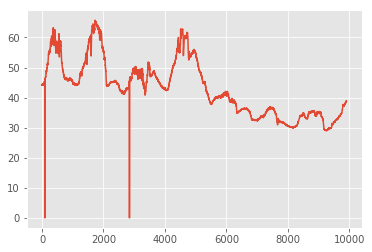

In [10]:
df2["Humidity (Internal)"].plot()

It is physically impossible for humidity to drop to 0 then climb back to 40 within a minute, this must be a "System fault" anomaly.

# Detecting Anomalies

Before we can automatically detect anomalies, we need to choose cut off threshold probabilities $\epsilon$ for each observable/measure. The choice for $\epsilon$ is subjective because this an unsupervised problem, we don't really know what are anomalies. A good choice for $\epsilon$ would be to manually look at the tails of the distribution and select a cutoff, then calculate the probability of this cutoff and use it as $\epsilon$. It would be nice if we could just choose $\epsilon$ to be $n\sigma$ for some n, however some of these processes have fat tails(high kurtosis), so even choosing a 10 sigma event might not be an anomaly. 

In [125]:
cut_offs = [0.001,0.2,30,30,30,0.12,18,0.19,1.5,0.7,2.5]
epsilons ={}
for i,idx in enumerate(stationary_idx+nonstationary_idx):
    measure = columns[idx]
#     if measure in columns[nonstationary_idx]:
#         std2 = 5*df2[measure].diff().values[1:].std()
#     else:
#         std2 = 5*df2[measure].values.std()
    model = models[measure]
    epsilon = model.pdf(cut_offs[i])[0]
                       
    epsilons[measure] = epsilon

Now that we have our cutoff probabilities we can automatically flag anomalies.

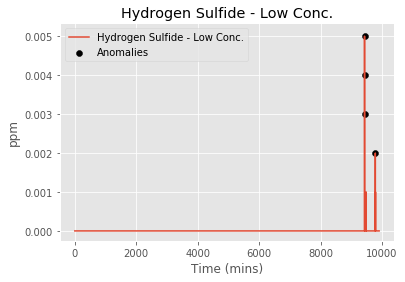

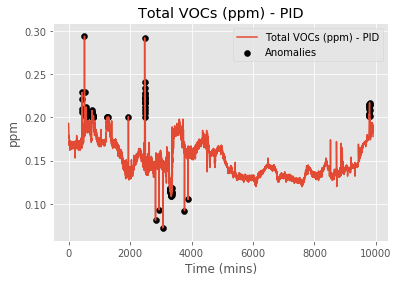

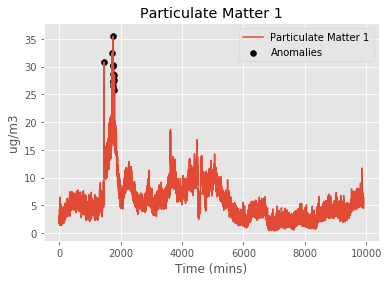

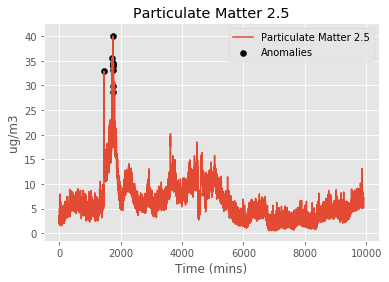

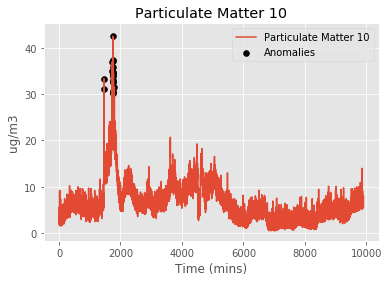

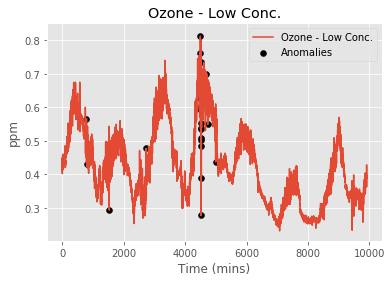

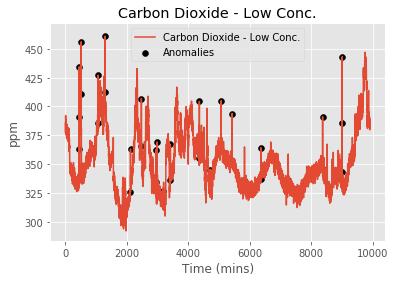

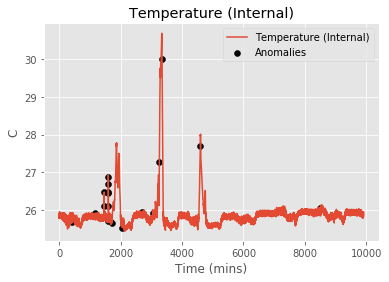

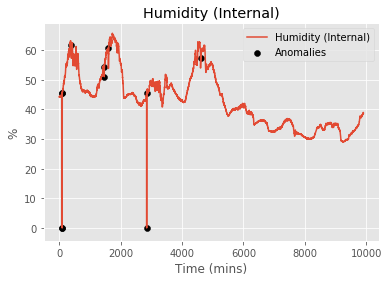

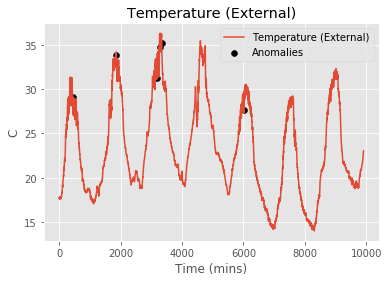

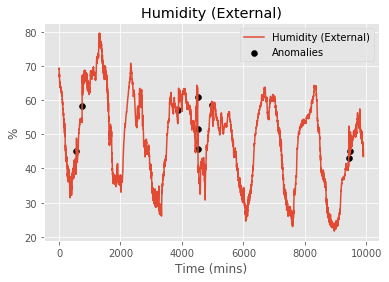

In [127]:
for idx in stationary_idx+nonstationary_idx:
    measure = columns[idx]
    if measure in columns[nonstationary_idx]:
        data = df2[measure].diff().values[1:]
    else:
        data = df2[measure].values
    anomalies = anomaly_detector(data,measure,epsilons[measure])
    plt.figure()
    plt.title(measure)
    plt.xlabel("Time (mins)")
    plt.ylabel(units[idx])
    df2[measure].plot()
    
    plt.scatter(anomalies[:,0],df2.iloc[anomalies[:,0]][measure].values, label='Anomalies', color='black')
    plt.legend()
        
    
    plt.show()
    

# Conclusion and Summary

To sum up, we have applied 3 different methods to detect and categorize anomalies. We began by looking at the frequency spectrum of some measurements, and argued that naturally there should be a strong daily frequency present. We then looked at the distribution of the data, applying Kernel Density Estimation to estimate a density for the data. Lastly we used the estimated densities as probability models to automatically flag extreme events as anomalies.

We compared the frequency spectrums of week 1 and week 2, and because the first week did not present a strong daily frequency we hypothesized that the first week of data contained strong "System fault" anomalies. To further support this hypothesize we looked at the distribution of the stationary data. We noticed that the mean, variance, and shape of the distribution were all different. In the first weeks data we had very extreme measurements for VOCs, $CO_2$, and Humidity. We also noticed a period between 5000-8000 mins where the change in activity was unusually low. This all lead us to the conclusion that the first weeks data was not properly sampled, there was a "System fault" for almost the entire week.

To automatically flag anomalies, we used the second weeks data to build probability models via Kernel Density Estimation. We used these models to identify extreme (improbable) events and mark them as anomalies. It's hard to tell the cause of these anomalies. Until we have more data and better definitions on what "System fault" and "External events" refer to, the best we can do is mark anomalies that as physically possible as "External event", and mark impossible anomalies as "System fault". An example of an impossible anomaly is the internal Humidity dropping by 40% to zero, so this would be a "System fault". 



# Extra

I didn't mention this above, but I think it's important to notice. When the external temperature gets too high, the internal temperature suddenly jumps. This is probably due to overheating or the sensors not being capable of recording in such temperatures. This should definitely be looked into more because this simple thing may be damaging the device/sensors.


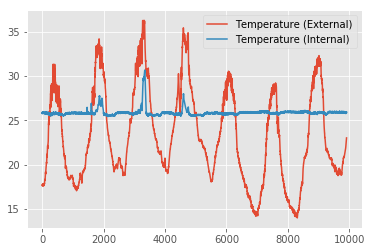

In [129]:
df2[["Temperature (External)", "Temperature (Internal)"]].plot()

The spikes in internal temperature occur when external temperature goes above 34 degrees 